<h1 style="text-align: center">
 </br> 
Image Segmentation with U-Net
</h1>


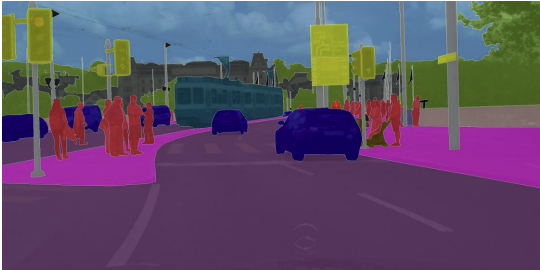 <br>
<u><b>Figure 1</u></b>: Example of a segmented image <br>

* Build your own U-Net
* Explain the difference between a regular CNN and a U-net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction


## Downloading Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install torch-summary
!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\gdown\cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3
To: C:\Users\Asus\Desktop\Deep learning\Hw\hw2\HW2\Files.zip

  0%|          | 0.00/545M [00:00<?, ?B/s]
  0%|          | 524k/545M [00:02<43:55, 206kB/s]
  0%|          | 1.05M/545M [00:05<45:08, 201kB/s]
  0%|          | 1.57M/545M [00:07<44:16, 204kB/s]
  0%|          | 2.10M/545M [00:10<44:55, 201kB/s]
  0%|          | 2.62M/545M [00:12<44:15, 204kB/s]
  1%|          | 3.15M/545M [00:15<44:45, 202kB/s]
  1%|          | 3.67M/545M [00:18<44:13, 204kB/s]
  1%|          | 4.19M/545M [00:20<43:48, 206kB/s]
  1%|          | 4.72M/545M [00:23<43:33, 207kB/s]
  1%|          | 5.24M/545M [00:25<44:05, 204kB/s]
  1%|1         | 5.77M/545M [00:28<43:58, 204kB/s]
 

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
path = '/content/Files/'
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

C:\Users\Asus\AppData\Local\Temp\ipykernel_19176\385303178.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Asus\AppData\Local\Temp\ipykernel_19176\385303178.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


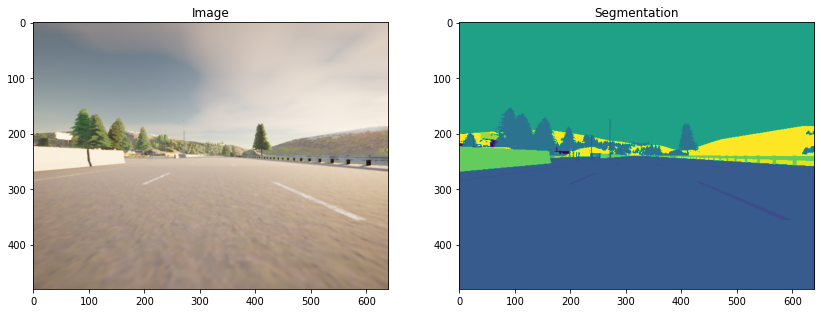

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show()

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [6]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory
        self.images = os.listdir(self.ImagesDirectory)
        self.masks = os.listdir(self.MasksDirectory)
        self.mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST)
        ])
        self.image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]

        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = io.read_file(img_path)
        img = io.decode_png(img)
        
        mask_path = os.path.join(self.MasksDirectory, img_name)
        mask = io.read_image(mask_path)
        mask, _ = torch.max(mask[0:3], dim=0, keepdim=True)
        img, mask = self.image_transforms(img), self.mask_transforms(mask)
        return {"IMAGE": img , "MASK": mask}


In [8]:
# TO DO
EPOCHS =  30
BATCH_SIZE = 64
LR = 1e-3
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 


<a name='3-1'></a>
### 3.1 - Model Details

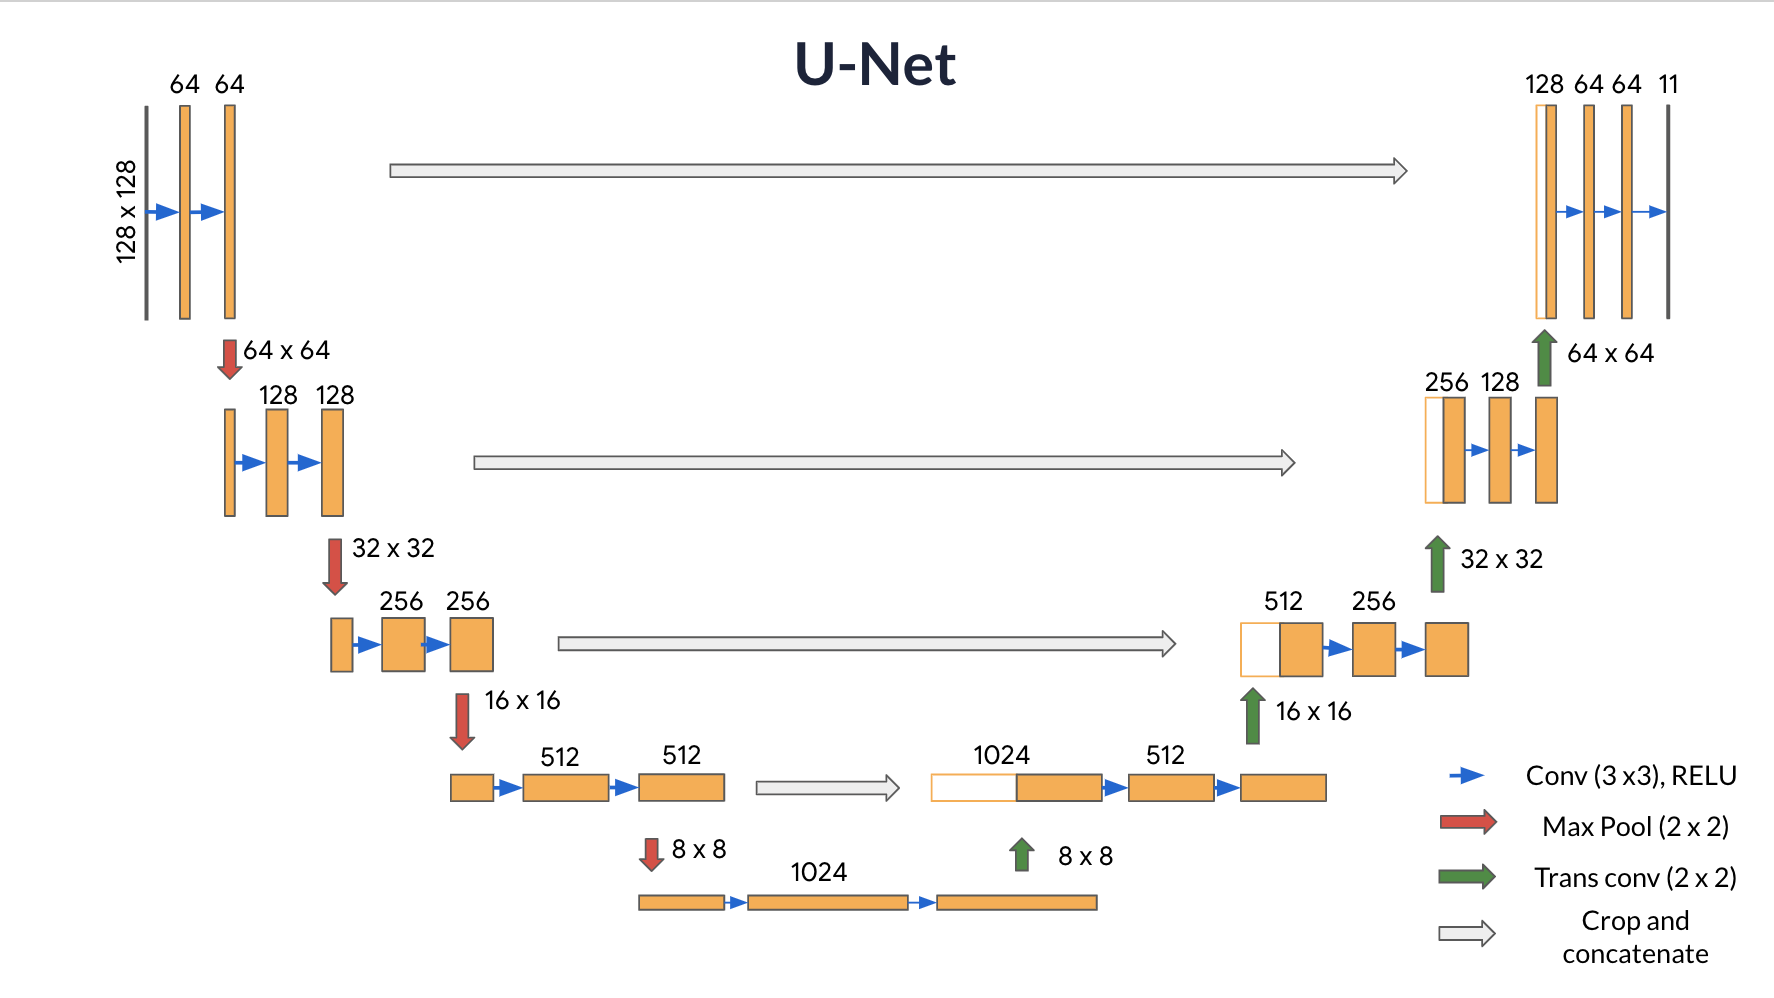<br>
<u><b> Figure 2 </u></b>: U-Net Architecture<br>






<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

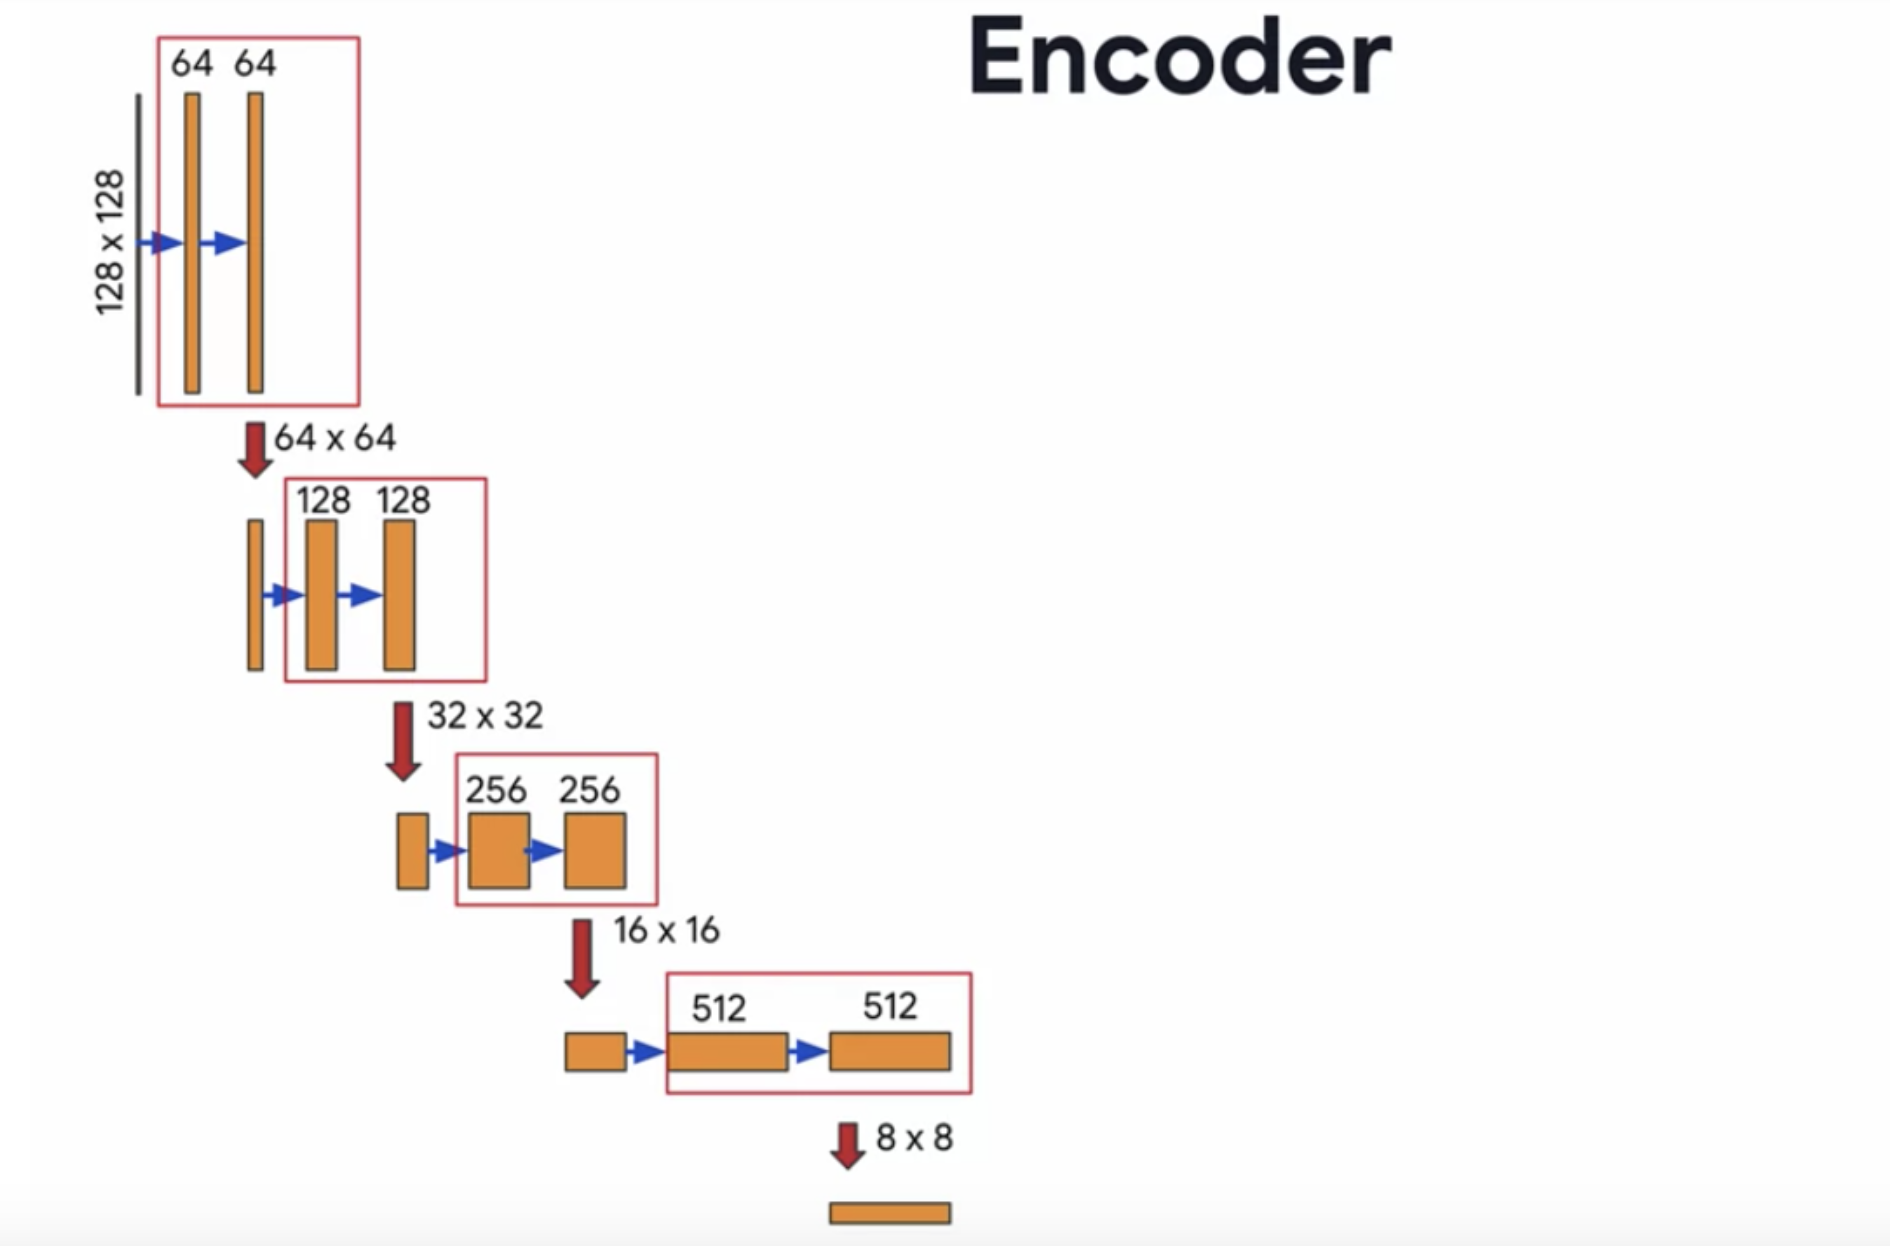<br>
<u><b>Figure 3</u></b>: The U-Net Encoder up close <br>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [9]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        """
        super(conv_block, self).__init__()
        
       
        self.conv1 = nn.Conv2d(in_ch, n_filters, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_prob)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_pooling = max_pooling

        
    def forward(self, x):
        """
        Convolutional downsampling forward

        Arguments:
            x -- Input data/batch
        Returns: 
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        skip_connection = self.dropout(x)
        if self.max_pooling:
            next_layer = self.pool(skip_connection)
        else:
            next_layer = skip_connection       
        return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

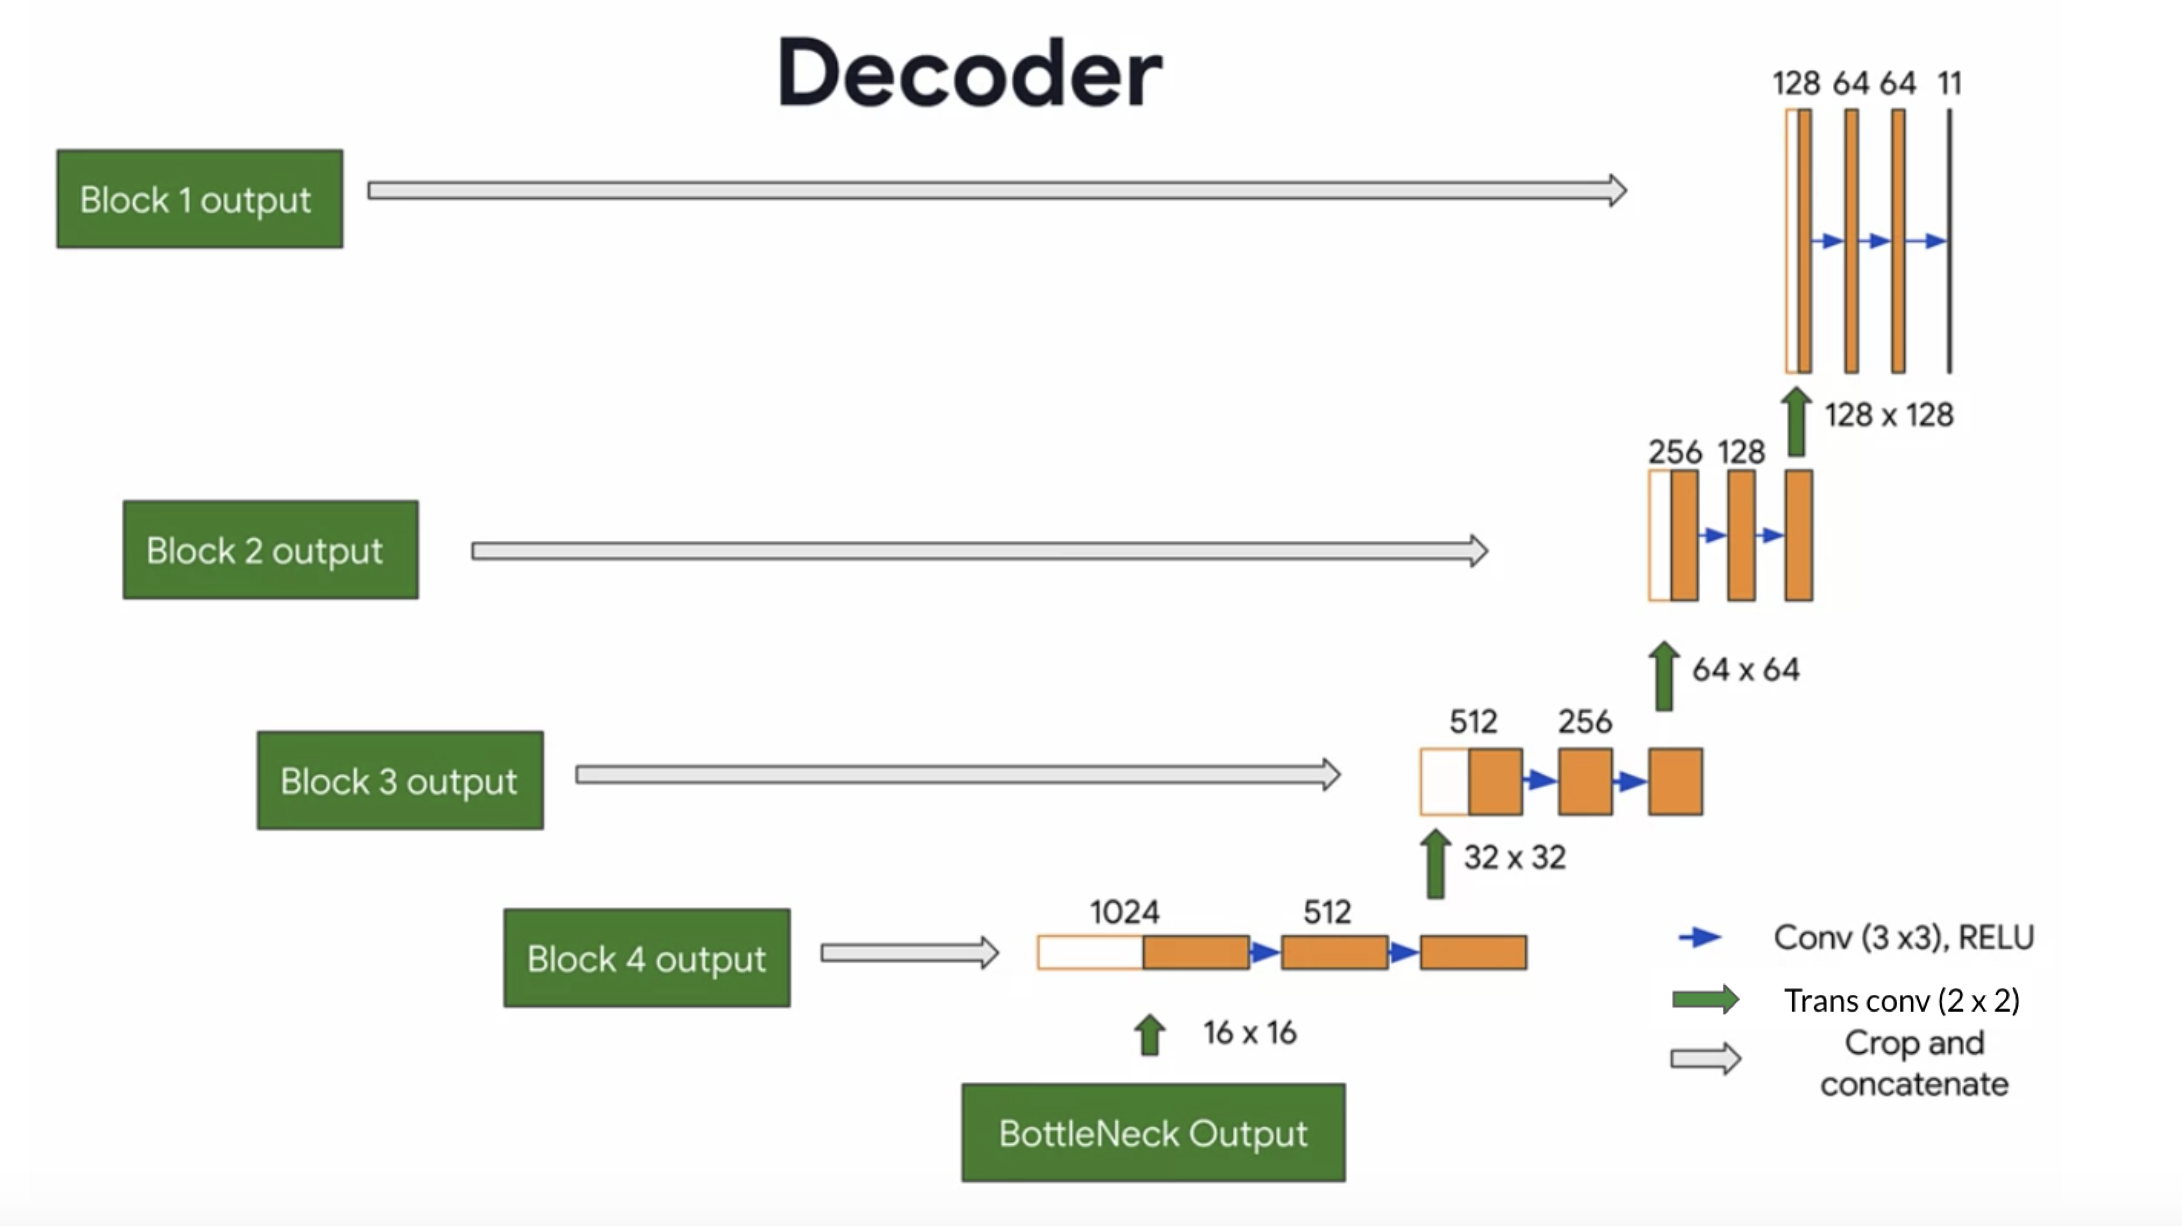<br>
<u><b>Figure 4</u></b>: The U-Net Decoder up close <br>





In [10]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block
        
        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        """
        super(upsampling_block, self).__init__()
       
        self.upconv = nn.ConvTranspose2d(in_ch,(in_ch//2 ), kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Conv2d((in_ch//2 + skip_ch), n_filters, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self,expansive_input, contractive_input):
        """
        Convolutional upsampling forward
        
        Arguments:
            expansive_input -- Data from bottleneck or previous upsampling_block
            contractive_input -- Data from corresponding layer in the encoder
        Returns: 
            conv -- Tensor output
        """     
        expansive_input = self.upconv(expansive_input)
        conv = torch.cat([expansive_input, contractive_input], axis=1)
        conv = self.conv1(conv)
        conv = self.relu1(conv)
        conv = self.conv2(conv)
        conv = self.relu2(conv)
        
        return conv


<a name='3-4'></a>
### 3.4 - Build the Model

 

In [11]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        """
        UNet
        
        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            n_filters -- Number of filters for the convolutional layers
            n_classes -- Number of diffrent segments
        """        
        super(UNet, self).__init__()
        # Down-sampling
        
        self.conv_block1 = conv_block(in_ch, n_filters) 
        self.conv_block2 = conv_block(n_filters, 2*n_filters)
        self.conv_block3 = conv_block(2*n_filters, 4*n_filters)  #64 
        self.conv_block4 = conv_block(4*n_filters, 8*n_filters,dropout_prob=0.3) #32
        
        self.conv_block5 = conv_block(8*n_filters, 16*n_filters, max_pooling=False)#16


        # Up-sampling
        
        
        self.upsample_block6 = upsampling_block(16*n_filters , 8*n_filters , 8*n_filters) 
        self.upsample_block7 = upsampling_block(8*n_filters , 4*n_filters , 4*n_filters)
        self.upsample_block8 = upsampling_block(4*n_filters , 2*n_filters , 2*n_filters) 
        self.upsample_block9 = upsampling_block(2*n_filters ,n_filters , n_filters) 
        self.conv = nn.Conv2d(n_filters , n_filters ,  kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.last_conv = nn.Conv2d(n_filters , n_classes , kernel_size=1)

    
    def forward(self , x):
        """
        UNet forward
        
        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """

        out,skip1 = self.conv_block1(x)
        out,skip2 = self.conv_block2(out)
        out,skip3 = self.conv_block3(out)
        out,skip4 = self.conv_block4(out)
        
        out,skip5 = self.conv_block5(out)
                
        out = self.upsample_block6(out, skip4)      
        out = self.upsample_block7(out, skip3)
        out = self.upsample_block8(out, skip2)
        out = self.upsample_block9(out, skip1)

        out = self.conv(out)
        out = self.relu3(out)
        out = self.last_conv(out)

        return out

### Check out the model summary below! 

In [12]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 32, 96, 128]         --
|    └─Conv2d: 2-1                       [-1, 32, 192, 256]        896
|    └─ReLU: 2-2                         [-1, 32, 192, 256]        --
|    └─Conv2d: 2-3                       [-1, 32, 192, 256]        9,248
|    └─ReLU: 2-4                         [-1, 32, 192, 256]        --
|    └─Dropout2d: 2-5                    [-1, 32, 192, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 96, 128]         --
├─ConvBlock: 1-2                         [-1, 64, 48, 64]          --
|    └─Conv2d: 2-7                       [-1, 64, 96, 128]         18,496
|    └─ReLU: 2-8                         [-1, 64, 96, 128]         --
|    └─Conv2d: 2-9                       [-1, 64, 96, 128]         36,928
|    └─ReLU: 2-10                        [-1, 64, 96, 128]         --
|    └─Dropout2d: 2-11                   [-1, 64, 96, 128]         --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 32, 96, 128]         --
|    └─Conv2d: 2-1                       [-1, 32, 192, 256]        896
|    └─ReLU: 2-2                         [-1, 32, 192, 256]        --
|    └─Conv2d: 2-3                       [-1, 32, 192, 256]        9,248
|    └─ReLU: 2-4                         [-1, 32, 192, 256]        --
|    └─Dropout2d: 2-5                    [-1, 32, 192, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 96, 128]         --
├─ConvBlock: 1-2                         [-1, 64, 48, 64]          --
|    └─Conv2d: 2-7                       [-1, 64, 96, 128]         18,496
|    └─ReLU: 2-8                         [-1, 64, 96, 128]         --
|    └─Conv2d: 2-9                       [-1, 64, 96, 128]         36,928
|    └─ReLU: 2-10                        [-1, 64, 96, 128]         --
|    └─Dropout2d: 2-11                   [-1, 64, 96, 128]         --
|  

<a name='3-6'></a>
### 3.6 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [13]:
dataloader = DataLoader(Segmentation_Dataset(image_path, mask_path), batch_size=BATCH_SIZE, shuffle=True)

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Asus\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

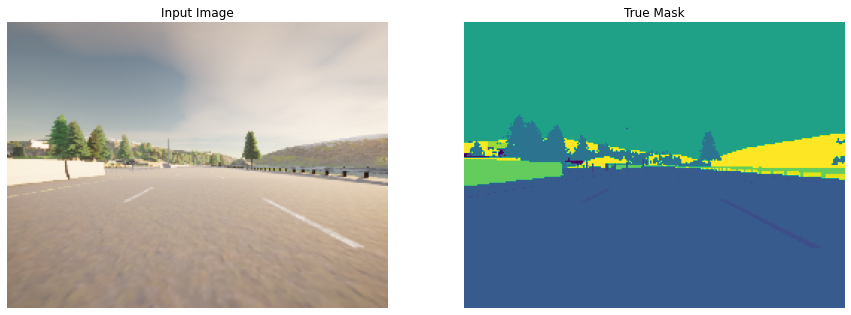

In [15]:

display_list = [dataloader.dataset[0]['IMAGE'],dataloader.dataset[0]['MASK']]
display(display_list)


<a name='3-7'></a>
### 3.7 - Loss Function



In [16]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))

<a name='4'></a>
## 4 - Train the Model

In [19]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(dataloader):

        # Hint: You might need to reshape MASK prior to      #
        #       calculating the loss using the code below:   #
        #       N, C, H, W = MASK.shape                      #
        #       MASK = MASK.reshape((N, H, W)).long()        #        
        images = batch["IMAGE"].to(device)
        masks = batch["MASK"].to(device)        
        optimizer.zero_grad()
        outputs = unet(images)
        N, C, H, W = masks.shape
        masks = masks.reshape((N, H, W)).long()
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        
        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    losses.append(np.mean(epoch_losses))


EPOCH#0,	 Batch#0,	 Loss:3.0567615032196045
EPOCH#0,	 Batch#1,	 Loss:3.047200918197632
EPOCH#0,	 Batch#2,	 Loss:3.0434086322784424
EPOCH#0,	 Batch#3,	 Loss:3.034888505935669
EPOCH#0,	 Batch#4,	 Loss:3.013657569885254
EPOCH#0,	 Batch#5,	 Loss:2.820195198059082
EPOCH#0,	 Batch#6,	 Loss:4.20638370513916
EPOCH#0,	 Batch#7,	 Loss:2.8600683212280273
EPOCH#0,	 Batch#8,	 Loss:2.97198486328125
EPOCH#0,	 Batch#9,	 Loss:2.989790678024292
EPOCH#0,	 Batch#10,	 Loss:2.9890239238739014
EPOCH#0,	 Batch#11,	 Loss:2.9875593185424805
EPOCH#0,	 Batch#12,	 Loss:2.9859888553619385
EPOCH#0,	 Batch#13,	 Loss:2.976555585861206
EPOCH#0,	 Batch#14,	 Loss:2.97869873046875
EPOCH#0,	 Batch#15,	 Loss:2.9599454402923584
EPOCH#0,	 Batch#16,	 Loss:2.948007106781006
EPOCH#1,	 Batch#0,	 Loss:2.9439375400543213
EPOCH#1,	 Batch#1,	 Loss:2.9234628677368164
EPOCH#1,	 Batch#2,	 Loss:2.898738145828247
EPOCH#1,	 Batch#3,	 Loss:2.8605077266693115
EPOCH#1,	 Batch#4,	 Loss:2.784121513366699
EPOCH#1,	 Batch#5,	 Loss:2.5601403713226

EPOCH#10,	 Batch#16,	 Loss:0.5683419108390808
EPOCH#11,	 Batch#0,	 Loss:0.5427184700965881
EPOCH#11,	 Batch#1,	 Loss:0.6031286120414734
EPOCH#11,	 Batch#2,	 Loss:0.5527452826499939
EPOCH#11,	 Batch#3,	 Loss:0.5795146822929382
EPOCH#11,	 Batch#4,	 Loss:0.5394018292427063
EPOCH#11,	 Batch#5,	 Loss:0.5605767369270325
EPOCH#11,	 Batch#6,	 Loss:0.5634575486183167
EPOCH#11,	 Batch#7,	 Loss:0.5861440300941467
EPOCH#11,	 Batch#8,	 Loss:0.537697970867157
EPOCH#11,	 Batch#9,	 Loss:0.4872952997684479
EPOCH#11,	 Batch#10,	 Loss:0.5806634426116943
EPOCH#11,	 Batch#11,	 Loss:0.5406433939933777
EPOCH#11,	 Batch#12,	 Loss:0.5601356625556946
EPOCH#11,	 Batch#13,	 Loss:0.5337046384811401
EPOCH#11,	 Batch#14,	 Loss:0.5284717679023743
EPOCH#11,	 Batch#15,	 Loss:0.5190337300300598
EPOCH#11,	 Batch#16,	 Loss:0.5306214690208435
EPOCH#12,	 Batch#0,	 Loss:0.5382661819458008
EPOCH#12,	 Batch#1,	 Loss:0.5155776739120483
EPOCH#12,	 Batch#2,	 Loss:0.48722031712532043
EPOCH#12,	 Batch#3,	 Loss:0.5537971258163452
EP

EPOCH#21,	 Batch#9,	 Loss:0.3762390911579132
EPOCH#21,	 Batch#10,	 Loss:0.3415926396846771
EPOCH#21,	 Batch#11,	 Loss:0.3468315601348877
EPOCH#21,	 Batch#12,	 Loss:0.3079128861427307
EPOCH#21,	 Batch#13,	 Loss:0.33978739380836487
EPOCH#21,	 Batch#14,	 Loss:0.32989415526390076
EPOCH#21,	 Batch#15,	 Loss:0.32750293612480164
EPOCH#21,	 Batch#16,	 Loss:0.30262497067451477
EPOCH#22,	 Batch#0,	 Loss:0.3118932545185089
EPOCH#22,	 Batch#1,	 Loss:0.3073192536830902
EPOCH#22,	 Batch#2,	 Loss:0.33373403549194336
EPOCH#22,	 Batch#3,	 Loss:0.34309300780296326
EPOCH#22,	 Batch#4,	 Loss:0.31682634353637695
EPOCH#22,	 Batch#5,	 Loss:0.31256166100502014
EPOCH#22,	 Batch#6,	 Loss:0.3075627386569977
EPOCH#22,	 Batch#7,	 Loss:0.3033730089664459
EPOCH#22,	 Batch#8,	 Loss:0.31990787386894226
EPOCH#22,	 Batch#9,	 Loss:0.32951459288597107
EPOCH#22,	 Batch#10,	 Loss:0.3050839602947235
EPOCH#22,	 Batch#11,	 Loss:0.3188886344432831
EPOCH#22,	 Batch#12,	 Loss:0.2990663945674896
EPOCH#22,	 Batch#13,	 Loss:0.302084

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [61]:
def create_mask(pred_mask):

    pred_mask = torch.argmax(pred_mask, dim=1)

  
    return pred_mask


<a name='4-2'></a>
### 4.2 - Plot Model Accuracy



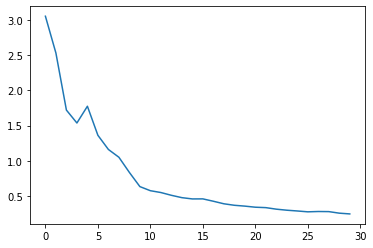

In [20]:
plt.plot(np.arange(len(losses)), losses)

###### <a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [39]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    for i, batch in enumerate(dataloader):
        IMG = batch["IMAGE"].to(device)
        MASK = batch["MASK"].to(device)

        pred_mask = unet(IMG)
        display([IMG[0], MASK[0],create_mask(pred_mask)[0].view([1,192, 256])]).show()

        if i >= num:
            break

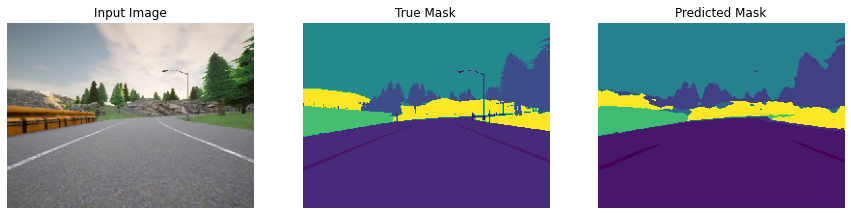

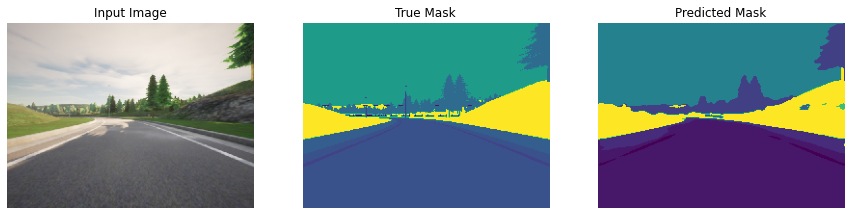

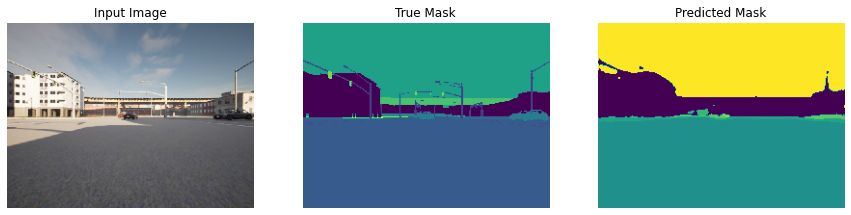

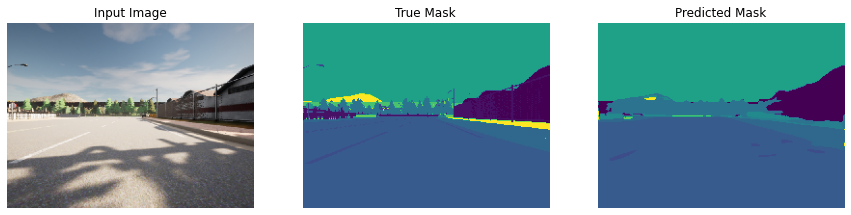

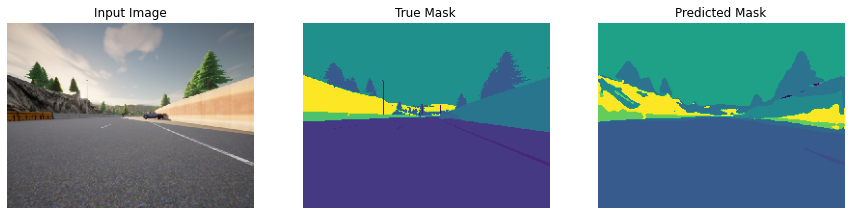

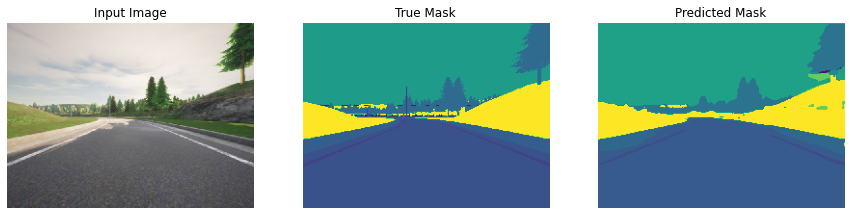

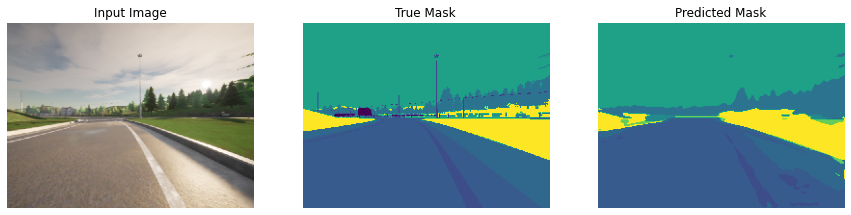

In [98]:
show_predictions(dataloader, device, 6)

<font color='blue'>
    
**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net